In [95]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nlp
import pydicom
import nibabel as nib
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import display, clear_output

import os
import os.path

import math

In [96]:
def plot_images(img_stack, *, labels=None, figdim=5, colormap=plt.cm.gray, show=True, **imshowkwarg):
    """
    Funzione di utilità per mostrare una grigli di immagini, impostando la lista delle legende
    e, opzionalmente, la colormap che di default è impostata a livelli di grigio
    """    
    nimag = len(img_stack)

    # creiamo il layout
    nrows = 1 if nimag <= 3 else 2 if nimag <= 6 else 3 if nimag <=12 else 4 if nimag <= 16 else 5
    ncols = nimag if nrows == 1 else 2 if nimag == 4 else 3 if nimag <=9 else 4 if nimag <= 16 else 5

    # generiamo la figura con un canvas ce riserva 5x5 pollici a immagine
    # e i riferimenti alle singole immagini
    fig, axs = plt.subplots(nrows,ncols,squeeze=False,figsize=(figdim*ncols, figdim*nrows))
    
    img = 0 # contatore delle immagini

    for r in range(nrows):
        for c in range(ncols):
            # eliminiamo lo stile del grafico
            axs[r, c].tick_params(axis='both',\
                    which='both',\
                    bottom=False,top=False,right=False,left=False,\
                    labelbottom=False,labelleft=False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)

            # se ci troviamo nella posizione di una
            # immagine allora la mostriamo
            if r*ncols + c < nimag:
                if labels != None:
                    axs[r, c].set_title(labels[img])
            
                axs[r, c].imshow(img_stack[img], cmap=colormap, **imshowkwarg)

                img += 1 # immagine successiva
    
    if show == True:
        plt.show()
    
    return axs

In [97]:
# Carichiamo una scansione EPI e analizziamo l'header
epi_data = nib.load('./Data/someones_epi.nii.gz')
print(epi_data.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 53 61 33  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 3. 3. 3. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.14943813
quatern_c       : -0.0
quatern_d       : -0.0
qoffset_x       : -78.0
qoffset_y       : -76.0
qoffset_z       : -64.0
srow_x          : [  3.   0.   0. -78.]
srow_y          : [

In [98]:
# Carichiamo una scansione MRI dello stesso soggetto
anat_data = nib.load('./Data/someones_anatomy.nii.gz')
print(anat_data.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 57 67 56  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.   2.75 2.75 2.75 1.   1.   1.   1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -78.0
qoffset_y       : -91.0
qoffset_z       : -91.0
srow_x          : [  2.75   0.     0.   -78.  ]
srow

In [99]:
# recuperiamo i dati e la trasformazione affine di entrambe le scansioni
epi_img = epi_data.get_fdata()
epi_affine = epi_data.affine

In [100]:
anat_img = anat_data.get_fdata()
anat_affine = anat_data.affine

In [101]:
print(epi_affine)
print(anat_affine)

[[  3.           0.           0.         -78.        ]
 [  0.           2.86600947  -0.88656062 -76.        ]
 [  0.           0.88656062   2.86600947 -64.        ]
 [  0.           0.           0.           1.        ]]
[[  2.75   0.     0.   -78.  ]
 [  0.     2.75   0.   -91.  ]
 [  0.     0.     2.75 -91.  ]
 [  0.     0.     0.     1.  ]]


In [102]:
print(epi_img.shape,anat_img.shape)

(53, 61, 33) (57, 67, 56)


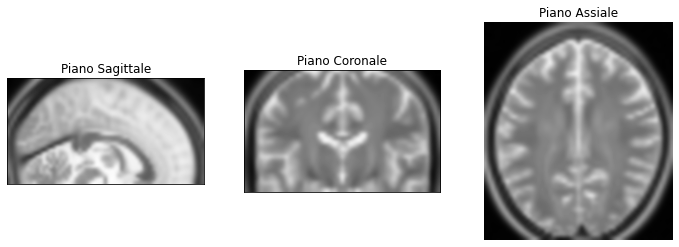

In [103]:
# Mostriamo come esempio le slice centrali del volume secondo tutti e tre i piani
axes = plot_images([epi_img[26,:,:].T,epi_img[:,30,:].T,epi_img[:,:,16].T],labels=['Piano Sagittale','Piano Coronale','Piano Assiale'],figdim=4,interpolation='bicubic',origin='lower')

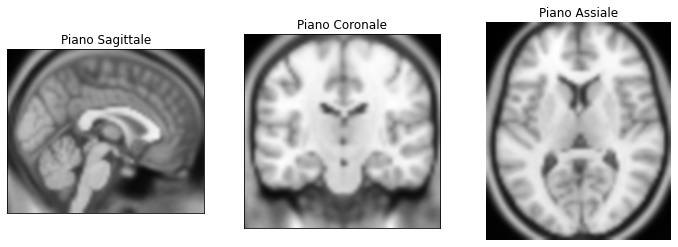

In [104]:
axes = plot_images([anat_img[28,:,:].T,anat_img[:,33,:].T,anat_img[:,:,28].T],labels=['Piano Sagittale','Piano Coronale','Piano Assiale'],figdim=4,interpolation='bicubic',origin='lower')

In [105]:
# Moltiplichiamo la matrice di cambio di coordinate della scansione anatomica
# verso le coordinate mondo per la matrice di trasformazione affine della scansione EPI
# per registrare le due 
epi_to_anat_affine = nlp.inv(anat_affine).dot(epi_affine)
print(epi_to_anat_affine)

[[ 1.09090909  0.          0.          0.        ]
 [ 0.          1.04218526 -0.32238568  5.45454545]
 [ 0.          0.32238568  1.04218526  9.81818182]
 [ 0.          0.          0.          1.        ]]


In [106]:
# selezioniamo i 4 vertici del rettangolo includente la slice 26
# sul piano sgittale per trasformarli e mostrarli nel piano saggittale della
# slice anatomica
epi_bb = np.array([[26, 0, 0],[26, 60, 0], [26, 60, 32], [26, 0, 32]])

anat_bb = nib.affines.apply_affine(epi_to_anat_affine,epi_bb)

# la prima coordinata del nuovo bounding box in ogni riga è l'indice di slice
print(anat_bb)

[[28.36363636  5.45454545  9.81818182]
 [28.36363636 67.98566125 29.16132259]
 [28.36363636 57.6693195  62.51125102]
 [28.36363636 -4.86179629 43.16811024]]


In [107]:
slice_idx = math.floor(anat_bb[0,0]) # slice 28

# costruiamo gli array "circolari" delle prime e delle seconde coordinate dei 
# vertici del rettangolo così che la plot stampi una figura chiusa
bb_coords = np.array([np.concatenate((anat_bb[:,1],anat_bb[0,1].reshape(1,))),\
                    np.concatenate((anat_bb[:,2],anat_bb[0,2].reshape(1,)))])


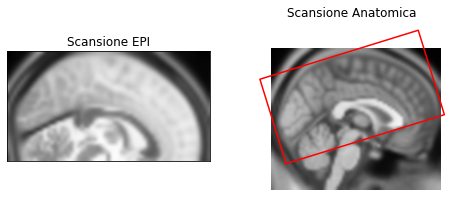

In [109]:
axes = plot_images([epi_img[26,:,:].T,anat_img[slice_idx,:,:].T],labels=['Scansione EPI','Scansione Anatomica'],figdim=4,show=False, interpolation='bicubic',origin='lower')

axes[0,1].plot(bb_coords[0,:],bb_coords[1,:],'r-')

plt.show()